In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets
from astropy.cosmology import Planck13 as cosmo
from scipy.integrate import quad
import numpy as np
import random
import sys
sys.path.append("..")
from src.mzr import am2013
from src.smf import baldry12
from src.umachine_sfhs import relative_ia_rate
from src.umachine_sfhs import _MASSES_ as umachine_masses
load_mpl_presets()
print(sys.version_info)

sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [34]:
path = "../mocksamples"
filenames = [
    "baldry_500_m0p3_z0p2_gamma0.dat",
    "baldry_500_m0p3_z0p2_gamma0p2.dat",
    "baldry_500_m0p3_z0p2_gamma0p5.dat",
    "baldry_500_m0p3_z0p2_gamma1p0.dat",
    "baldry_500_m0p3_z0p2_gamma2p0.dat"
]
mocksamples = [np.genfromtxt("%s/%s" % (path, _)) for _ in filenames]

def mass_weighted_baldry(mass):
    return mass * baldry12(mass)

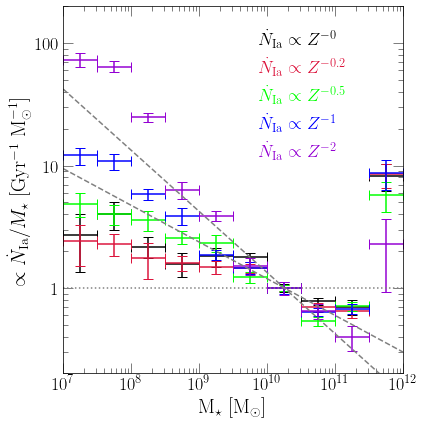

In [58]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel(r"M$_\star$ [M$_\odot$]")
ax.set_ylabel(r"$\propto \dot{N}_\text{Ia} / M_\star$ [Gyr$^{-1}$ M$_\odot^{-1}$]")
ax.set_xlim([10**7, 10**12])
ax.set_ylim([0.2, 200])

nbins = 10
njack = 10
log_mstar_bins = np.linspace(7, 12, nbins + 1)
plaw_indeces = [0, 0.2, 0.5, 1, 2]
colors = ["black", "crimson", "lime", "blue", "darkviolet"]
idx = 0
while log_mstar_bins[idx] < 10: idx += 1
random.seed(a = 0)

for i in range(len(mocksamples)):
    log_mstar = [row[0] for row in mocksamples[i]]
    rates = nbins * [0]
    yerr = nbins * [0.]
    for j in range(len(rates)):
        arr = list(filter(lambda x: log_mstar_bins[j] <= x <= log_mstar_bins[j + 1], log_mstar))
        rates[j] = len(arr)
        jack_subs = [int(njack * _) for _ in np.random.random_sample(size = len(arr))]
        jack_rates = njack * [len(arr)]
        for k in range(len(arr)): jack_rates[jack_subs[k]] -= 1
        mean_jack_rate = np.mean(jack_rates)
        for k in range(njack): yerr[j] += (jack_rates[k] - mean_jack_rate)**2
        yerr[j] *= (njack - 1) / njack
        yerr[j] = np.sqrt(yerr[j])
        
        norm = quad(mass_weighted_baldry, 10**log_mstar_bins[j], 10**log_mstar_bins[j + 1])[0]
        rates[j] /= norm
        yerr[j] /= norm
        
    pre = 1 / rates[idx]
    rates = [pre * _ for _ in rates]
    yerr = [pre * _ for _ in yerr]

    xvals = [10**((a + b) / 2) for a, b in zip(log_mstar_bins[1:], log_mstar_bins[:-1])]
    xerr = [
        [a - 10**b for a, b in zip(xvals, log_mstar_bins[:-1])],
        [10**a - b for a, b in zip(log_mstar_bins[1:], xvals)]
    ]
    kwargs = {
        "yerr": yerr,
        "xerr": xerr,
        "color": named_colors()[colors[i]],
        "linestyle": "None"
    }
    ax.errorbar(xvals, rates, **kwargs)
    
    # dummy lines for drawing the legend
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\dot{N}_\text{Ia} \propto Z^{-%g}$" % (plaw_indeces[i])
    }
    ax.plot([10, 20], [10, 20], **kwargs)
    
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "bbox_to_anchor": (0.88, 0.98)
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)
for i in range(len(mocksamples)):
    leg.legendHandles[i].set_visible(False)
    
xvals = np.logspace(7, 12, 100)
yvals = [(_ / 10**((log_mstar_bins[idx] + log_mstar_bins[idx + 1]) / 2))**-0.5 for _ in xvals]
kwargs = {
    "c": named_colors()["grey"],
    "linestyle": '--'
}
ax.plot(xvals, yvals, **kwargs)
yvals = [(_ / 10**((log_mstar_bins[idx] + log_mstar_bins[idx + 1]) / 2))**-0.3 for _ in xvals]
ax.plot(xvals, yvals, **kwargs)
ax.axhline(1, c = named_colors()["grey"], linestyle = ':')

plt.tight_layout()
plt.show()